# Notebook 43: Second Wind Model - with Krticka+Bjorklund mix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path

import astropy.constants as ct
import astropy.units as u

import mesa_reader as mr

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
nb_id = 43

In [7]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon/03_ZdivZsun_8d-1'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [8]:
plt.style.use('./plotstyle.mplstyle')

In [9]:
Z_SUN = 0.014

### Utilities

In [10]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [11]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [12]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [38]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, p, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = f'{float(p.lstrip("p")):.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [14]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [15]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax

In [16]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [17]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

In [18]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r_to_plot = np.concatenate((np.arange(0.5, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 40, 10)))
    for i, r in enumerate(r_to_plot):
        r_y = log_l_const_rad(hd_x, r)
        ax.plot(hd_x, r_y, 'k--', lw=0.5, alpha=0.5)
        
        # label every two lines
        if not i%2:
            rotation = -np.arctan((r_y[10]-r_y[0])/(hd_x[10]-hd_x[0]))/np.pi*180       
            r_y_ = r_y[(hd_x >= xlim[1]) & (hd_x <= xlim[0])]
            y = r_y_[np.argmin(np.abs(r_y_-ylim[1]))]     
            x = hd_x[np.argmin(np.abs(r_y-y))]
            if (x < max(xlim) and x > min(xlim)) and (y < max(ylim) and y > min(ylim)):
                ax.text(
                    x, 
                    y,
                    f'${r:.1f}\\,\\mathrm{{R}}_\\odot$',
                    rotation=rotation,
                    ha='left',
                    va='top', 
                    fontsize=6,
                    alpha=0.8
                    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

For now we only have models with mass variations, where all other settings fixed. These are $\delta_\mathrm{mesh}=1$, $Z=\mathrm{Z}_\odot/10$, $Y_0=0.4$ and $\delta Y=0.3$.

In [39]:
model_ids = np.arange(1, 25, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/03_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/03_ZdivZsun_8d-1/002_md1_m25_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/03_ZdivZsun_8d-1/003_md1_m30_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/03_ZdivZsun_8d-1/004_md1_m35_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/03_ZdivZsun_8d-1/005_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/03_ZdivZsun_8d-1/006_md1_m45_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/03_ZdivZsun_8d-1/007_md1_m50_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/03_ZdivZsun_8d-1/008_md1_m55_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fid

Let's check the stellar models available.

In [383]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_b21_k18/000_m40_test:
		(m1/msun) 40.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_orb/d) 0.70
			(p_orb/d) 0.75
			(p_orb/d) 0.80
			(p_orb/d) 0.85
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.20
			(p_orb/d) 1.30
			(p_orb/d) 1.40
			(p_orb/d) 1.50
			(p_orb/d) 1.60
			(p_orb/d) 1.70
			(p_orb/d) 1.80
			(p_orb/d) 1.90
			(p_orb/d) 2.00
			(p_orb/d) 2.10
			(p_orb/d) 2.20
			(p_orb/d) 2.30
			(p_orb/d) 2.40
			(p_orb/d) 2.50
			(p_orb/d) 2.60
			(p_orb/d) 2.80
			(p_orb/d) 3.00
			(p_orb/d) 3.20
			(p_orb/d) 3.40
			(p_orb/d) 3.60
			(p_orb/d) 3.80
			(p_orb/d) 4.00
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_b21_k18/001_m300_test:
		(m1/msun) 300.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_orb/d) 0.70
			(p_

In [26]:
from matplotlib.lines import Line2D

import sys
sys.path.append('..')
from src.star import fix_unit

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Text(0.5, 1.0, '$40.0\\,\\mathrm{M}_\\odot$')

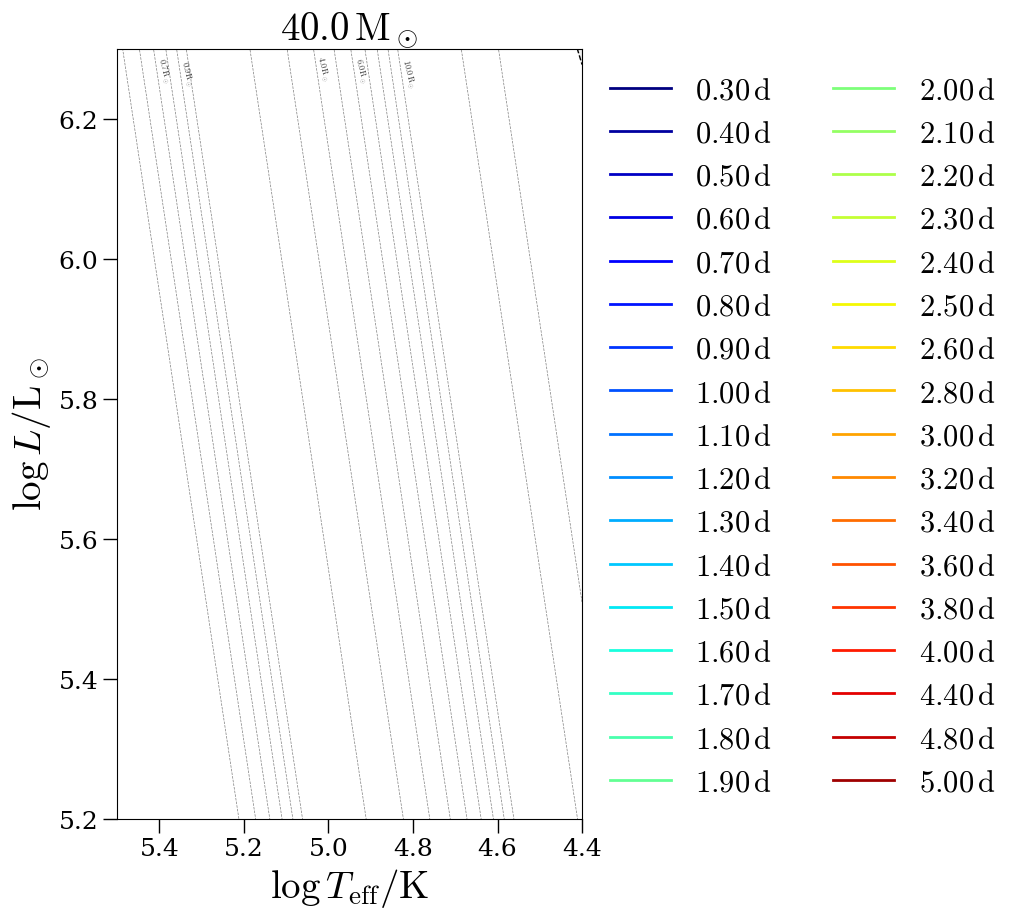

In [27]:
fig, ax = plt.subplots(figsize=(6, 10))
test_m = '40.0'

models_to_plot = [0]
model_style_list = ['-']
xlim = (5.5, 4.4)
ylim = (5.2, 6.3)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')
#ax.vlines(5, 5.8, 6.2, color='k', linestyles='-', linewidth=0.5)
#ax.vlines(np.log10(1.41e5), 5.8, 6.2, color='k', linestyles='--', linewidth=0.5)


Model /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon/03_ZdivZsun_8d-1/002_md1_m25_zsundiv10_04y0_03dy/m2.500d+01_p3.500d-01_w2.078d-04 failed to load.


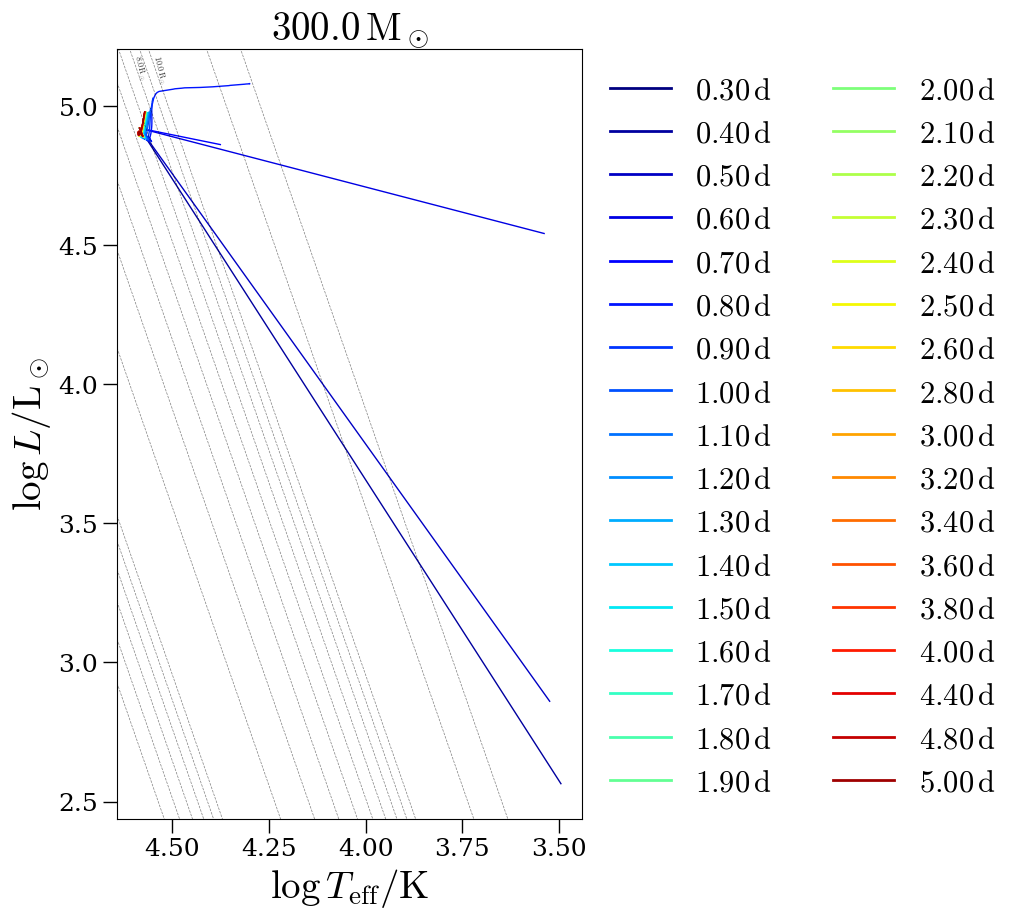

In [28]:
fig, ax = plt.subplots(figsize=(6, 10))
test_m = '300.0'

models_to_plot = [1]
model_style_list = ['-']
xlim = None
ylim = None
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')
ax.vlines(5.15, 5.8, 6.2)

| Abbreviation | Meaning |
|-----------------|-----------------|
| MS  | Main Sequence  |
| VMS  | Very Massive Main Sequence ($>100\,\mathrm{M}_\odot$)  |
| WR  | Wolf-Rayet  |
| lWR | low-luminosity Wolf-Rayet |
| hWR | high-luminosity Wolf-Rayet |
| CHE | Chemically Homogeneous Evolution |

In [29]:
def edd_gamma(x, l, m):
    return 10**-4.813 * (1+x) * l/m

def vink2001_w(l, m, teff, z):
    teff_jump = 61.2 + 2.59*(-13.636+0.889*np.log10(z/Z_SUN))
    dteff_jump = 100
    
    if teff > 27.5e3:
        a = 1
    elif teff < 22.5e3:
        a = 0
    else:
        if teff > teff_jump+dteff_jump:
            a = 1
        elif teff < teff_jump-dteff_jump:
            a = 0
        else:
            a = (teff-(teff_jump-dteff_jump))/(2*dteff_jump)
    
    if a > 0:
        vinf_div_vesc = 2.6*(z/Z_SUN)**0.13
        log_mdot = (-6.697
                    +2.194*np.log10(l/1e5)
                    -1.313*np.log10(m/30)
                    -1.226*np.log10(vinf_div_vesc/2)
                    +0.933*np.log10(teff/4e4)
                    -10.92*np.log10(teff/4e4)**2
                    +0.85*np.log10(z/Z_SUN))
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
    
    if a < 1:
        vinf_div_vesc = 1.3*(z/Z_SUN)**0.13
        log_mdot = (-6.688
                    +2.210*np.log10(l/1e5)
                    -1.339*np.log10(m/30)
                    -1.601*np.log10(vinf_div_vesc/2)
                    +1.07*np.log10(teff/4e4)
                    +0.85*np.log10(z/Z_SUN))
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0

    w = a*mdot1 + (1-a)*mdot2
    return w

def bjorklund2021_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

def krticka2018_w(l, z):
    log_mdot = (-5.7
                +0.5*np.log10(z/Z_SUN)
                +(1.61 - 0.12*np.log10(z/Z_SUN)) * np.log10(l/1e6)
                )
    w = 10.**log_mdot
    return w

def sabhahit2023_switch_g(z):
    l = sabhahit2023_switch_l(z)
    m = sabhahit2023_switch_m(z)
    return 2.5e-5 * l/m

def sabhahit2023_switch_l(z):
    return 10.**2.36 * z**-1.91

def sabhahit2023_switch_m(z):
    return 0.0615 * z**-1.574 + 18.1

def vink2011_w(l, m, z):
    logmdot_switch = -1.86*np.log10(z) - 8.9
    l_switch = sabhahit2023_switch_l(z)
    m_switch = sabhahit2023_switch_m(z)
    w = 10.**logmdot_switch * (l/l_switch)**4.77 * (m/m_switch)**-3.99
    return w

def sabhahit2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    g_e_switch = sabhahit2023_switch_g(z)
    dg_e = 0.01
    
    if g_e > g_e_switch+dg_e:
        a = 1
    elif g_e < g_e_switch-dg_e:
        a = 0
    else:
        a = (g_e-(g_e_switch-dg_e))/(2*dg_e) 
    
    if a > 0:
        w1 = vink2011_w(l, m, z)
    else:
        w1 = 0
    
    if a < 1:
        w2 = bjorklund2021_w(l, m, teff, z, x)
    else:
        w2 = 0
        
    w = a*w1 + (1-a)*w2
    return w
sabhahit2023_w = np.vectorize(sabhahit2023_w)

In [30]:
def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w

In [31]:
def sander2020_w(g_e, z):
    g_eb = -0.324*np.log10(z/Z_SUN) + 0.244
    c = -0.44*np.log10(z/Z_SUN) + 9.15
    d = 0.23*np.log10(z/Z_SUN) - 2.61
    
    #print(g_eb, c, d, g_e, z)
    
    log_mdot = 2.932 * np.log10(-np.log10(1-g_e)) - np.log10(2) * (g_eb/g_e)**c + d
    #print(2.932 , np.log10(-np.log10(1-g_e)), np.log10(2), (g_eb/g_e), c, d)
    w = 10.**log_mdot
    return w

In [32]:
def sander2023_w(l, m, t_eff, z, x):
    g_e = edd_gamma(x, l, m)
    #print(g_e)
    w20 = sander2020_w(g_e, z)
    #print(w20)
    if t_eff > 1.e5:
        log_mdot = np.log10(w20) - 6*np.log10(t_eff/1.e5)
        w = 10.**log_mdot
    else:
        w = w20
    return w

In [47]:
def winds(l, m, teff, z, x, y):
    x0 = 0.6
    dx = 0.3
    
    g_e = edd_gamma(x, l, m)
    g_switch = sabhahit2023_switch_g(z)
    d_gswitch = 0.01
    
    #MS or WR winds
    if x > x0:
        y_a = 0
    elif x < x0-dx:
        y_a = 1
    else:
        y_a = (x0-x)/(dx)
  
        
    bjorklund2021_winds = bjorklund2021_w(l, m, teff, z, x)
    krticka2018_winds = krticka2018_w(l, z)
    vink2011_winds = vink2011_w(l, m, z)
    vink2017_winds = vink2017_w(l, z)
    sander2023_winds = sander2023_w(l, m, teff, z, x)
    
    if g_e < g_switch:
        ms_w = min(bjorklund2021_winds, krticka2018_winds)
    else:
        ms_w = vink2011_winds
    
    w = y_a*max(vink2017_winds, sander2023_winds) + (1-y_a) * ms_w
    return w
    

In [48]:
wind_test_h = mr.MesaData(str(model_dicts[13]['110.0']['2.60']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]

wind_test_age = wind_test_h.star_age[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]

b21_winds = np.array([
    bjorklund2021_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v01_winds = np.array([
    vink2001_w(l, m, t, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])
v11_winds = np.array([
    vink2011_w(l, m, z) for l, m, z in zip(wind_test_l, wind_test_m, wind_test_z)
])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
k18_winds = np.array([
    krticka2018_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
])
full_winds = np.array([
    winds(l, m, t, z, x, y) for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

g_switch = np.array([
    sabhahit2023_switch_g(z) for z in wind_test_z
    ])

In [42]:
v01_winds_45kK = np.array([
    vink2001_w(l, m, 45000, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])

In [43]:
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

(-8.0, -3.0)

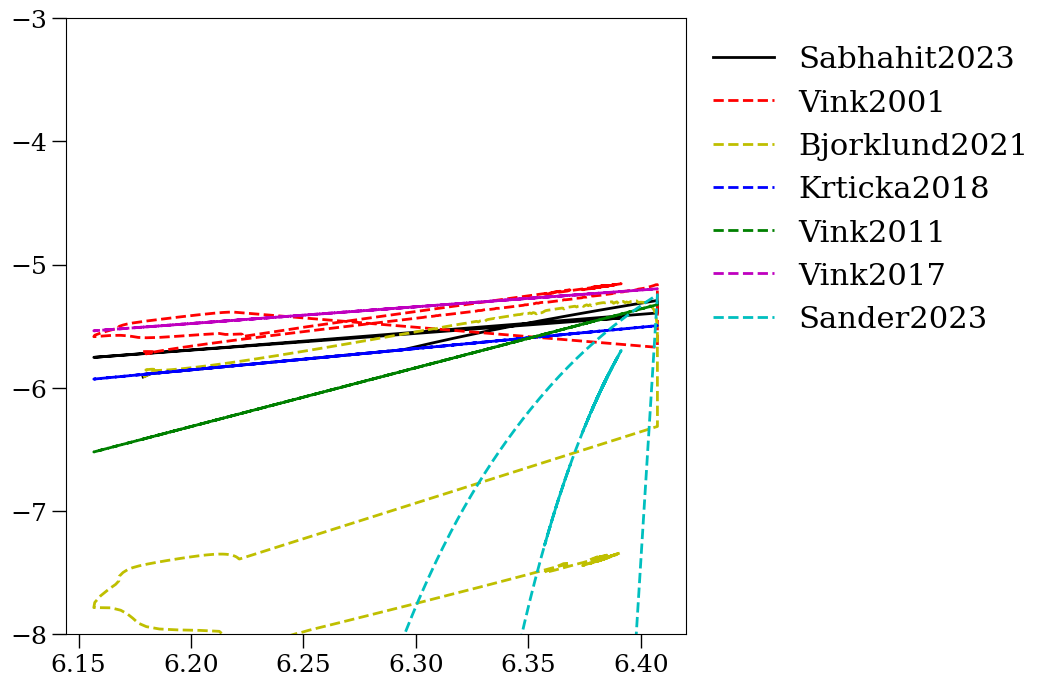

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_l), np.log10(full_winds), 'k-', label='Sabhahit2023')
ax.plot(np.log10(wind_test_l), np.log10(v01_winds), 'r--', label='Vink2001')
ax.plot(np.log10(wind_test_l), np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(np.log10(wind_test_l), np.log10(k18_winds), 'b--', label='Krticka2018')
ax.plot(np.log10(wind_test_l), np.log10(v11_winds), 'g--', label='Vink2011')

ax.plot(np.log10(wind_test_l), np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(np.log10(wind_test_l), np.log10(s23_winds), 'c--', label='Sander2023')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

#ax.set_xlim(5.3, 6.2)
ax.set_ylim(-8, -3)

(-10.0, -2.0)

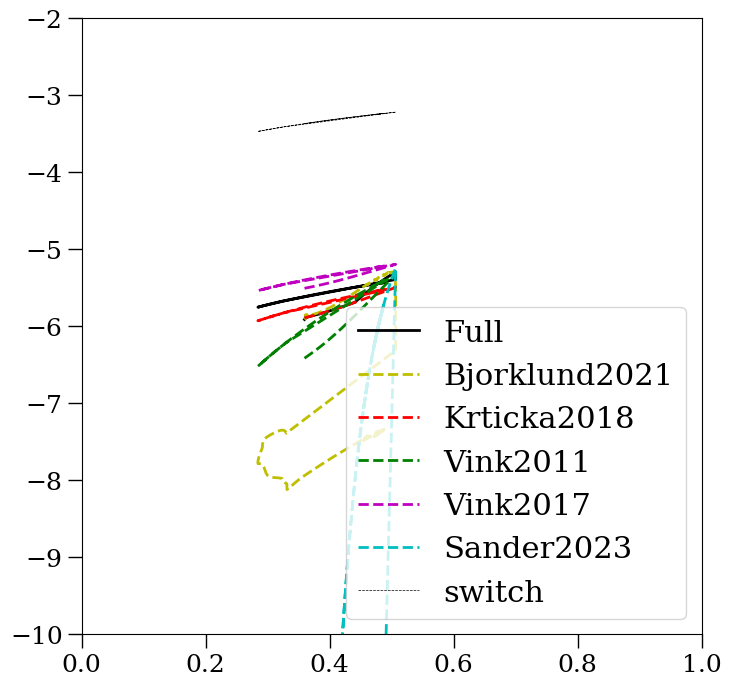

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wind_test_g, np.log10(full_winds), 'k-', label='Full')
ax.plot(wind_test_g, np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(wind_test_g, np.log10(k18_winds), 'r--', label='Krticka2018')
ax.plot(wind_test_g, np.log10(v11_winds), 'g--', label='Vink2011')
ax.plot(wind_test_g, np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(wind_test_g, np.log10(s23_winds), 'c--', label='Sander2023')
ax.plot(wind_test_g, np.log10(wind_test_g/g_switch)-3, 'k--', lw=0.5, label='switch')
ax.legend()

ax.set_xlim(0, 1)
ax.set_ylim(-10, -2)


(-10.0, -2.0)

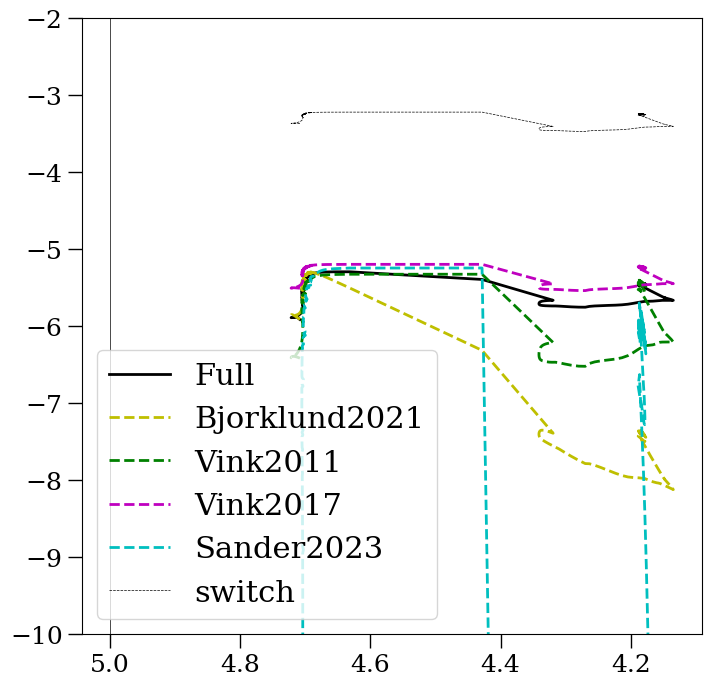

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_t), np.log10(full_winds), 'k-', label='Full')
ax.plot(np.log10(wind_test_t), np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(np.log10(wind_test_t), np.log10(v11_winds), 'g--', label='Vink2011')
ax.plot(np.log10(wind_test_t), np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(np.log10(wind_test_t), np.log10(s23_winds), 'c--', label='Sander2023')
ax.plot(np.log10(wind_test_t), np.log10(wind_test_g/g_switch)-3, 'k--', lw=0.5, label='switch')
ax.invert_xaxis()
ax.legend()
ax.vlines(5, -10, -2, color='k', lw=0.5)

#ax.set_xlim(0, 1)
ax.set_ylim(-10, -2)

In [55]:
wind_test_h.log_abs_mdot

array([-99., -99., -99., ..., -99., -99., -99.])

In [52]:
mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
mesa_rotational_logmdot = np.log10(10.**mesa_wind_rot - 10.**mesa_wind)

/tmp/ipykernel_652303/701155789.py:3: RuntimeWarning: divide by zero encountered in divide
  mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
/tmp/ipykernel_652303/701155789.py:5: RuntimeWarning: invalid value encountered in log10
  mesa_rotational_logmdot = np.log10(10.**mesa_wind_rot - 10.**mesa_wind)


/tmp/ipykernel_652303/999531447.py:6: RuntimeWarning: divide by zero encountered in divide
  ax.plot(wind_test_model_n, 10.**mesa_wind_rot/wind_test_h.rotational_mdot_boost[wind_test_start_i:], 'm-', lw=0.5)


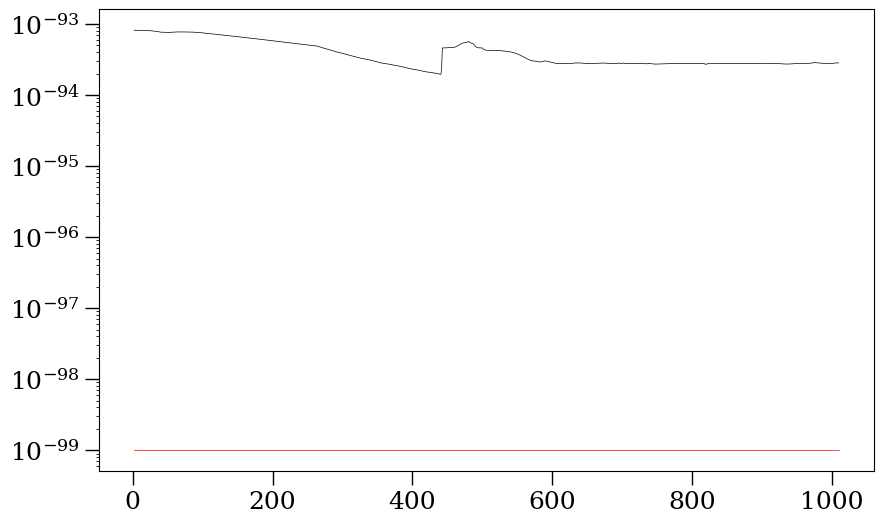

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wind_test_model_n, 10.**mesa_wind_rot, 'r-', lw=0.5)
ax.plot(wind_test_model_n, 10.**mesa_wind_rot/full_winds, 'k-', lw=0.5)
ax.plot(wind_test_model_n, wind_test_h.rotational_mdot_boost[wind_test_start_i:], 'b-', lw=0.5)
ax.plot(wind_test_model_n, 10.**mesa_wind_rot/wind_test_h.rotational_mdot_boost[wind_test_start_i:], 'm-', lw=0.5)
ax.set_yscale('log')

Text(0, 0.5, '$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

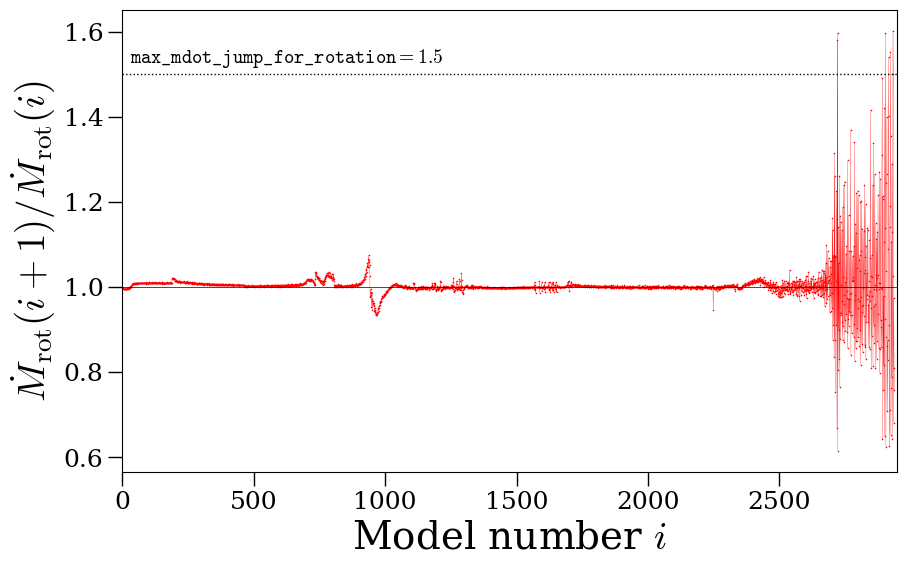

In [401]:
fig, ax = plt.subplots(figsize=(10, 6))

mdot_wind_jump = 10.**mesa_rotational_logmdot[1:]/10.**mesa_rotational_logmdot[:-1]
ax.plot(mdot_wind_jump, 'rx-', lw=0.2, markersize=0.5)
ax.hlines(1, 0, 3000, color='k', lw=0.5)
ax.set_xlim(0, len(mdot_wind_jump)+10)

ax.hlines(1.5, 0, 3000, color='k', ls=':', lw=1)
ax.text(30, 1.51, '$\\tt{max\\_mdot\\_jump\\_for\\_rotation=1.5}$', ha='left', va='bottom', fontsize=14)

ax.set_xlabel('Model number $i$')
ax.set_ylabel('$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

Text(0, 0.5, '$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

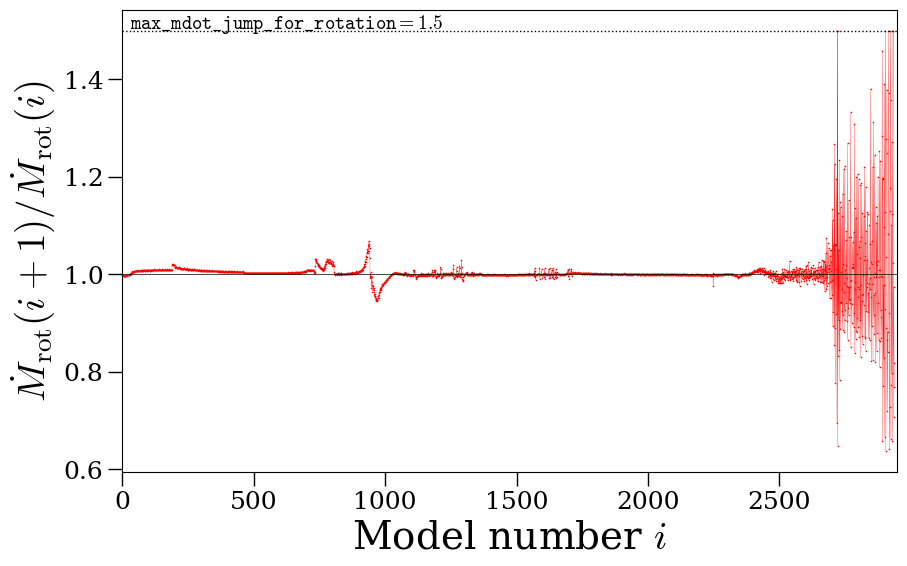

In [402]:
fig, ax = plt.subplots(figsize=(10, 6))

mdot_wind_jump = 10.**mesa_wind_rot[1:]/10.**mesa_wind_rot[:-1]
ax.plot(mdot_wind_jump, 'rx-', lw=0.2, markersize=0.5)
ax.hlines(1, 0, 3000, color='k', lw=0.5)
ax.set_xlim(0, len(mdot_wind_jump)+10)

ax.hlines(1.5, 0, 3000, color='k', ls=':', lw=1)
ax.text(30, 1.49, '$\\tt{max\\_mdot\\_jump\\_for\\_rotation=1.5}$', ha='left', va='bottom', fontsize=14)

plt.xlabel('Model number $i$')
plt.ylabel('$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

/tmp/ipykernel_113957/2826861368.py:17: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_113957/2826861368.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


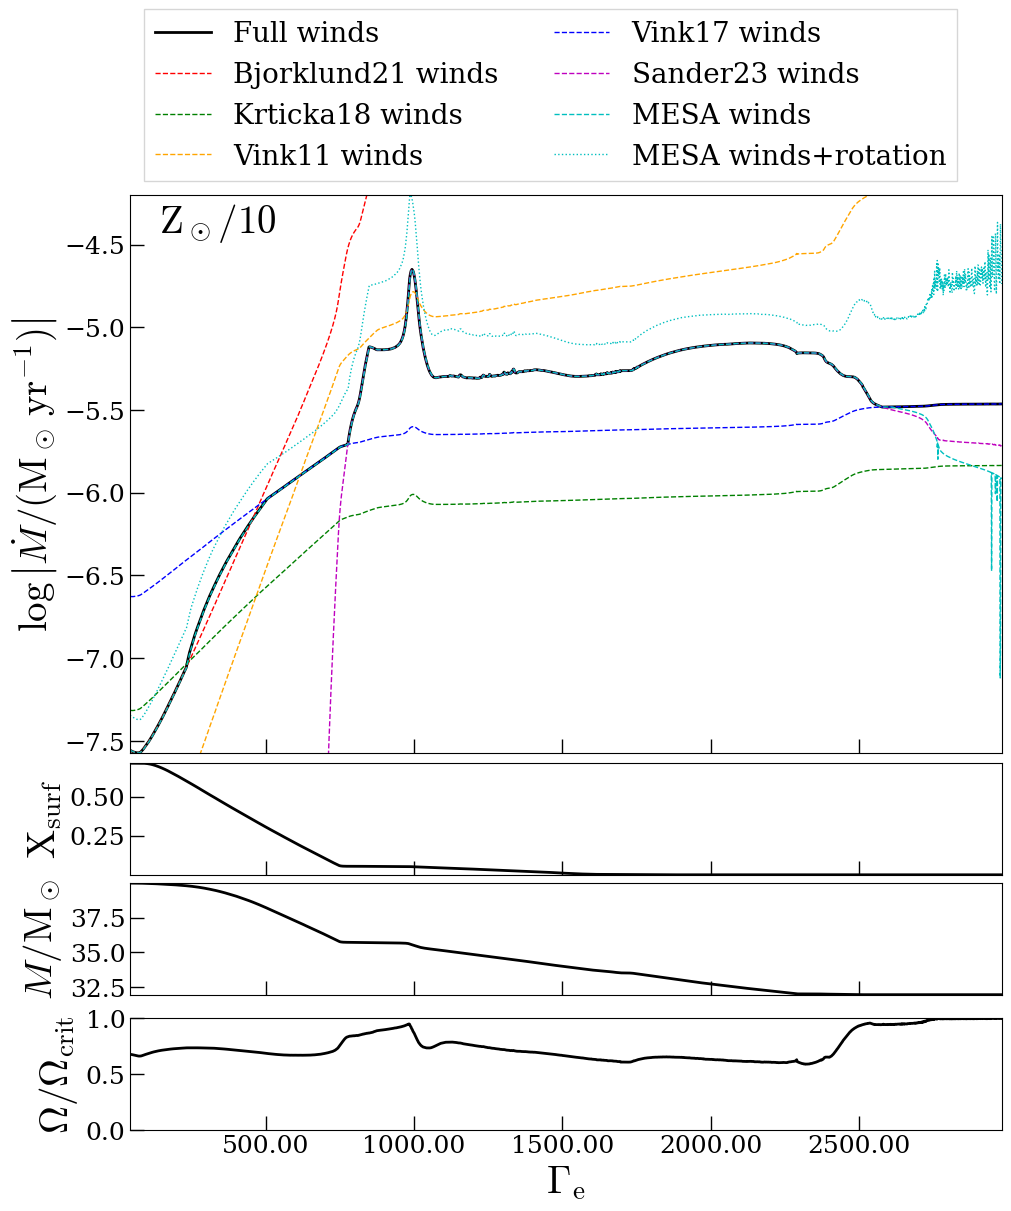

In [403]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_model_n
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = x[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = x[y1_i]
except:
    y1_log_l = maxy + 1
    
#ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

#ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

#ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\Gamma_\\mathrm{e}$')

#ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_eddgamma_m40_p060_zsun_div_10')

/tmp/ipykernel_113957/926707055.py:17: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_113957/926707055.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


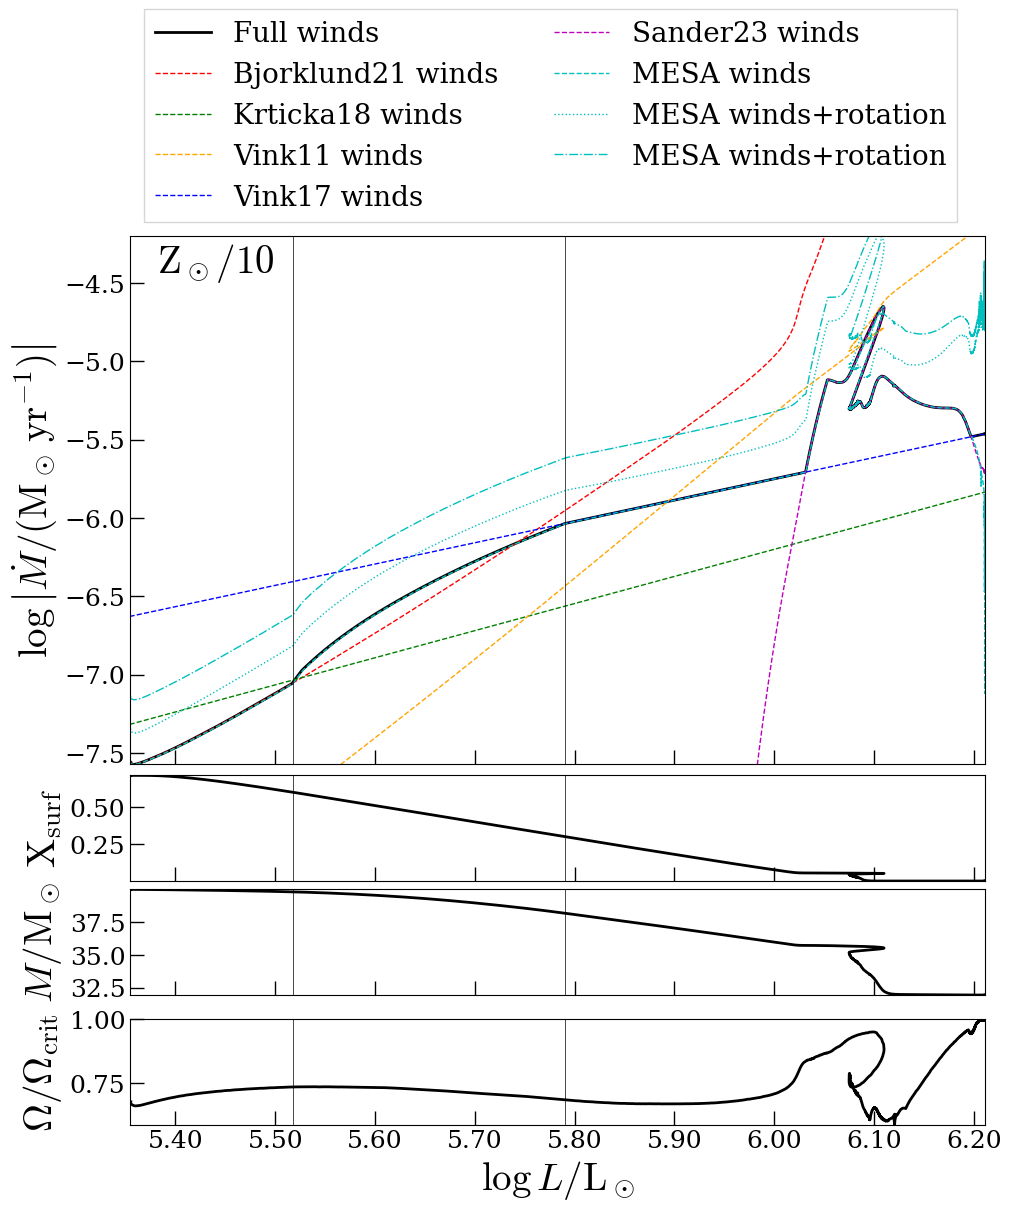

In [377]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)
ax0.plot(wind_test_h.log_L[wind_test_start_i:], np.log10(10.**mesa_wind_rot+10.**mesa_wind), 'c-.', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_m40_p060_zsun_div_10')

/tmp/ipykernel_113957/632979289.py:17: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_113957/632979289.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


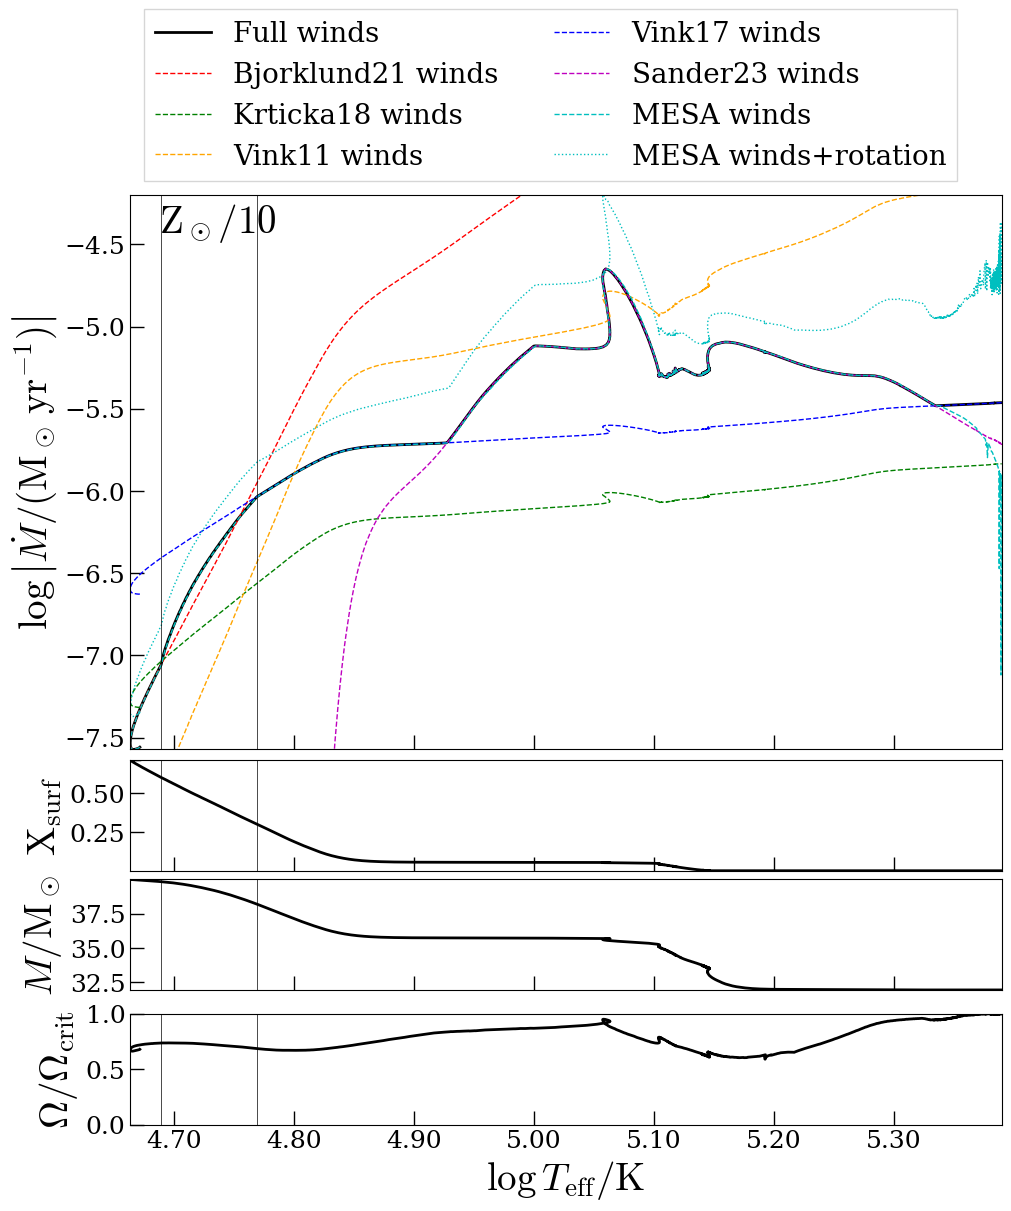

In [378]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_t)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_Teff[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_h.log_Teff[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_Teff[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_Teff[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_teff_m40_p060_zsun_div_10')

/tmp/ipykernel_113957/723071273.py:17: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_113957/723071273.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


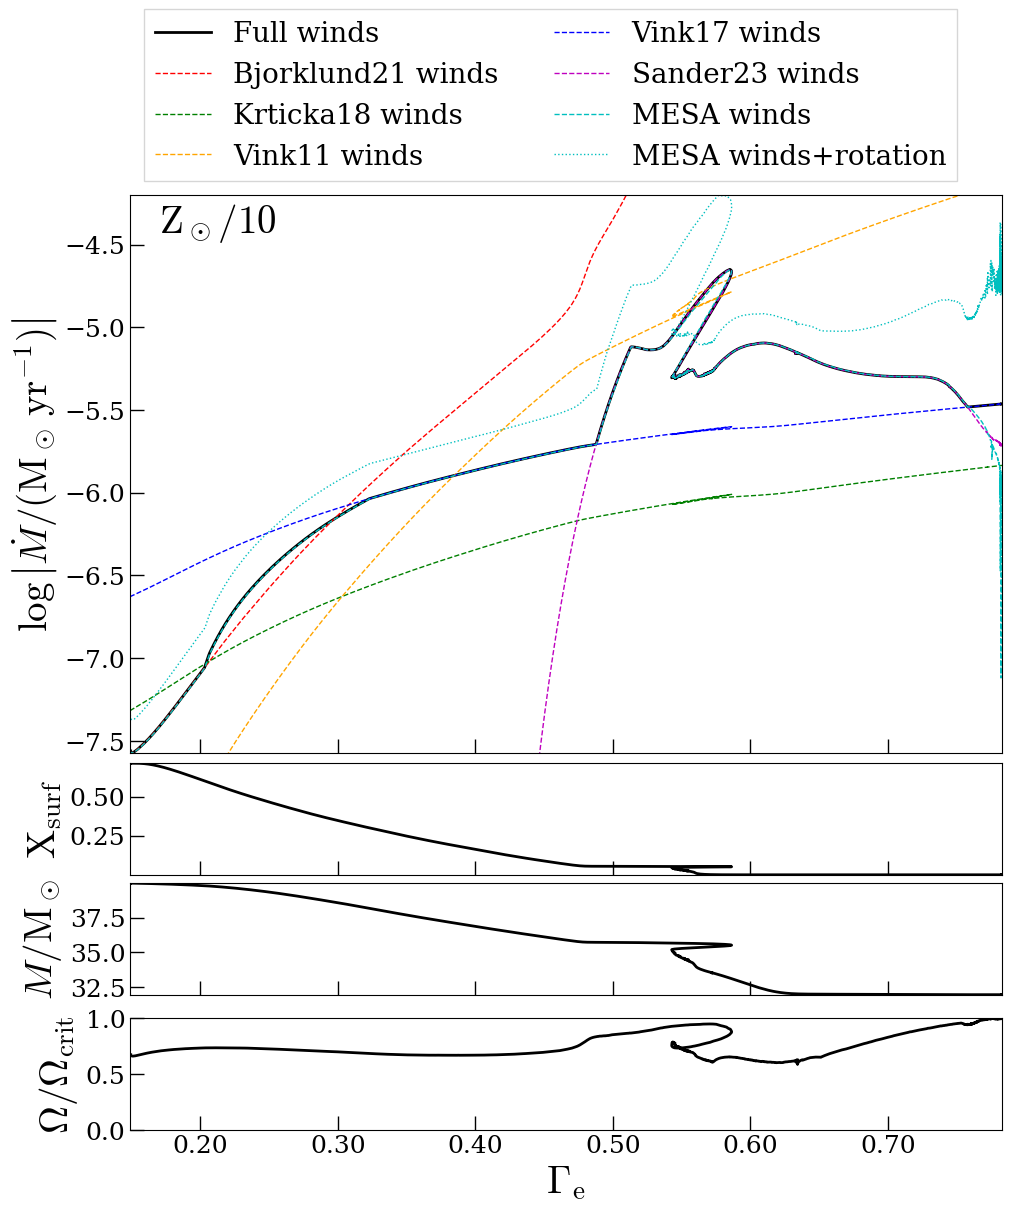

In [379]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_g
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_g, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_g, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_g
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_g
except:
    y1_log_l = maxy + 1
    
#ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_g, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

#ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_g, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

#ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(wind_test_g, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\Gamma_\\mathrm{e}$')

#ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_eddgamma_m40_p060_zsun_div_10')

/tmp/ipykernel_113957/2127760473.py:17: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_113957/2127760473.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


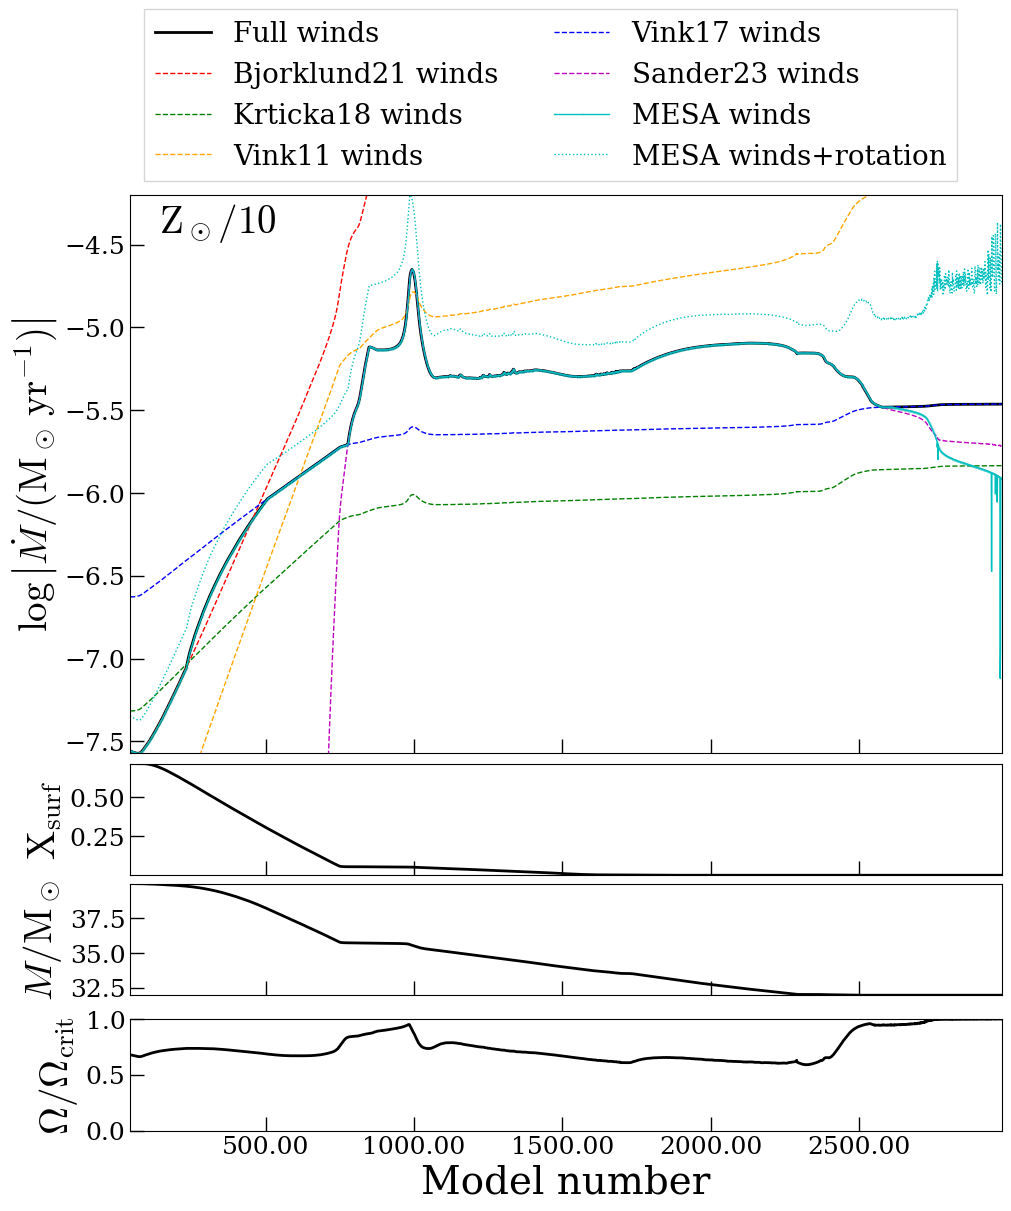

In [380]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_model_n
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'co-', label='MESA winds', lw=1, markersize=0.1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = x[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = x[y1_i]
except:
    y1_log_l = maxy + 1
    
#ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

#ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

#ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('Model number')

#ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_eddgamma_m40_p060_zsun_div_10')

/tmp/ipykernel_113957/3197302260.py:17: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_113957/3197302260.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


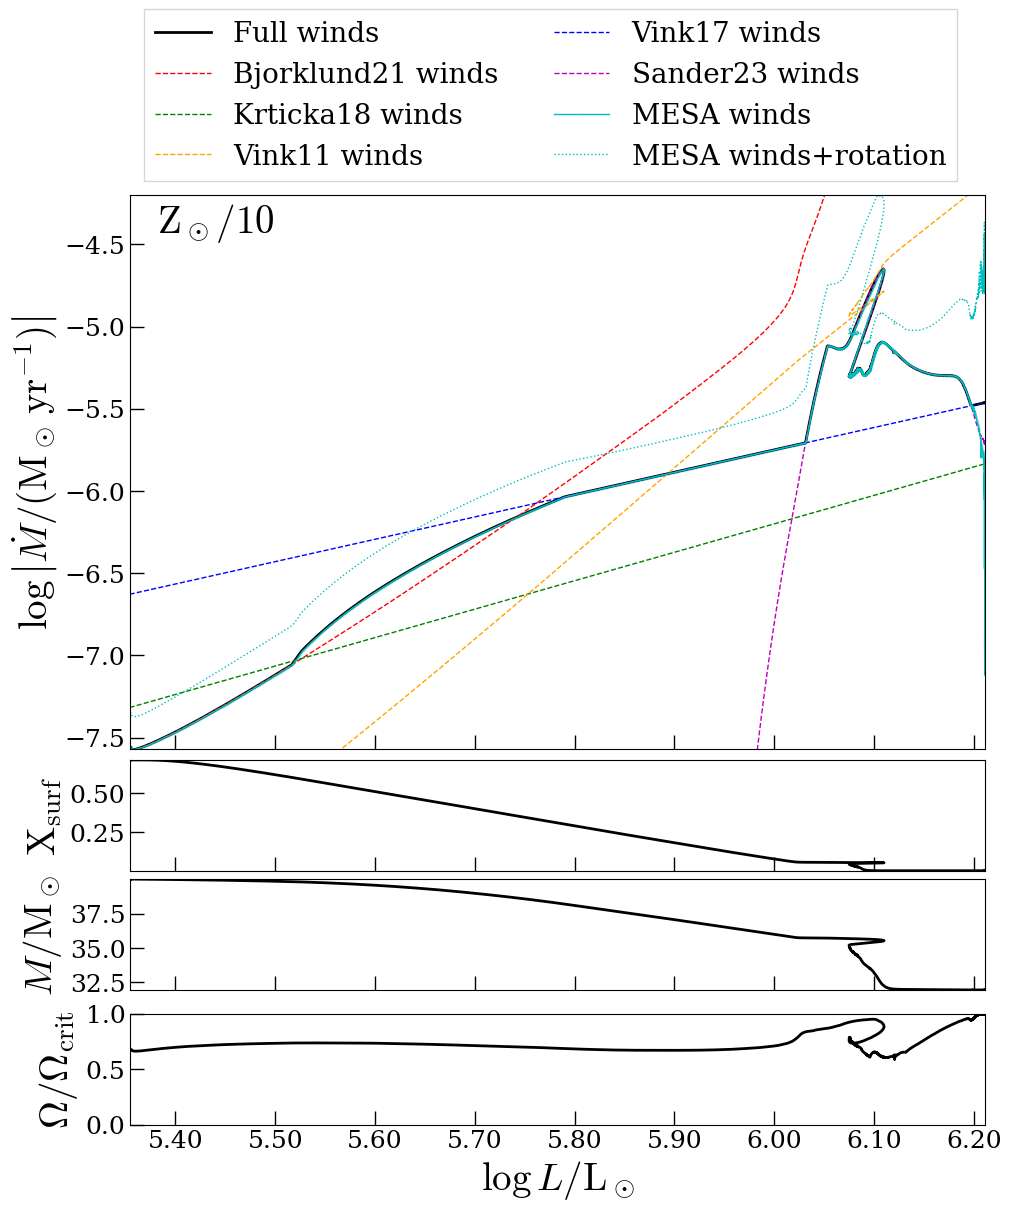

In [381]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'co-', label='MESA winds', lw=1, markersize=0.1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = x[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = x[y1_i]
except:
    y1_log_l = maxy + 1
    
#ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

#ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

#ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

#ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_eddgamma_m40_p060_zsun_div_10')

In [195]:
def terminal_v(l, m, r, z, x):
    g_e = edd_gamma(x, l, m)
    m *= u.Msun
    r *= u.Rsun
    v = (2.6
         * np.sqrt((2*ct.G.cgs * m * (1-g_e))/r)
         * (z/Z_SUN)**0.2
         )
    v = v.to(u.cm/u.s)
    return v.value

def ter_esc_v_ratio(l, m, z, x):
    g_e = edd_gamma(x, l, m)
    ratio = 2.6 * np.sqrt(1-g_e) * (z/Z_SUN)**0.2
    return ratio

def wind_eta(mdot, l, m, r, z, x):
    mdot *= u.Msun/u.yr
    ter_v = terminal_v(l, m, r, z, x) * u.cm/u.s
    eta = (mdot * ter_v / (l*u.Lsun/ ct.c)).to(u.dimensionless_unscaled)
    return eta.value

def wind_f(l, m, z, x):
    v_ratio = ter_esc_v_ratio(l, m, z, x)
    f = 0.75/(1+v_ratio**-2)
    return f

In [198]:
test_wind_eta_b21 = wind_eta(
    b21_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_eta_k18 = wind_eta(
    k18_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_eta_v01 = wind_eta(
    v01_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_f = wind_f(
    wind_test_l,
    wind_test_m,
    wind_test_z,
    wind_test_x
)

(0.01, 100)

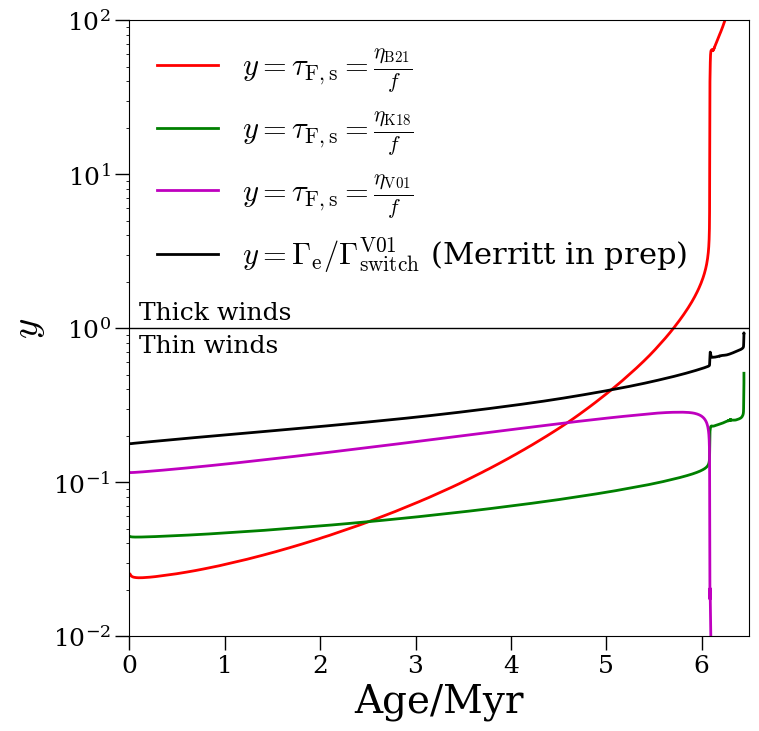

In [200]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wind_test_age/1e6, test_wind_eta_b21/test_wind_f, 'r-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{B21}}{f}$')
ax.plot(wind_test_age/1e6, test_wind_eta_k18/test_wind_f, 'g-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{K18}}{f}$')
ax.plot(wind_test_age/1e6, test_wind_eta_v01/test_wind_f, 'm-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{V01}}{f}$')
ax.plot(wind_test_age/1e6, wind_test_g/g_switch, 'k-', label='$y=\\Gamma_\\mathrm{e}/\\Gamma_\\mathrm{switch}^\\mathrm{V01}$ (Merritt in prep)')
ax.set_yscale('log')

ax.legend(frameon=False)

ax.set_xlabel('Age/Myr')
ax.set_ylabel('$y$')

ax.hlines(1, 0, 7, color='k', lw=1)
ax.set_xlim(0, 6.5)

ax.text(0.1, 0.9, 'Thin winds', ha='left', va='top', fontsize=18)
ax.text(0.1, 1.05, 'Thick winds', ha='left', va='bottom', fontsize=18)

ax.set_ylim(0.01, 100)

# 300 Mo

In [340]:
wind_test_h = mr.MesaData(str(model_dicts[1]['300.0']['4.00']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b21_winds = np.array([
    bjorklund2021_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v01_winds = np.array([
    vink2001_w(l, m, t, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])
v11_winds = np.array([
    vink2011_w(l, m, z) for l, m, z in zip(wind_test_l, wind_test_m, wind_test_z)
])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
])
k18_winds = np.array([
    krticka2018_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
full_winds = np.array([
    winds(l, m, t, z, x, y) for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

g_switch = np.array([
    sabhahit2023_switch_g(z) for z in wind_test_z
    ])

In [341]:
v01_winds_45kK = np.array([
    vink2001_w(l, m, 45000, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])

In [342]:
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

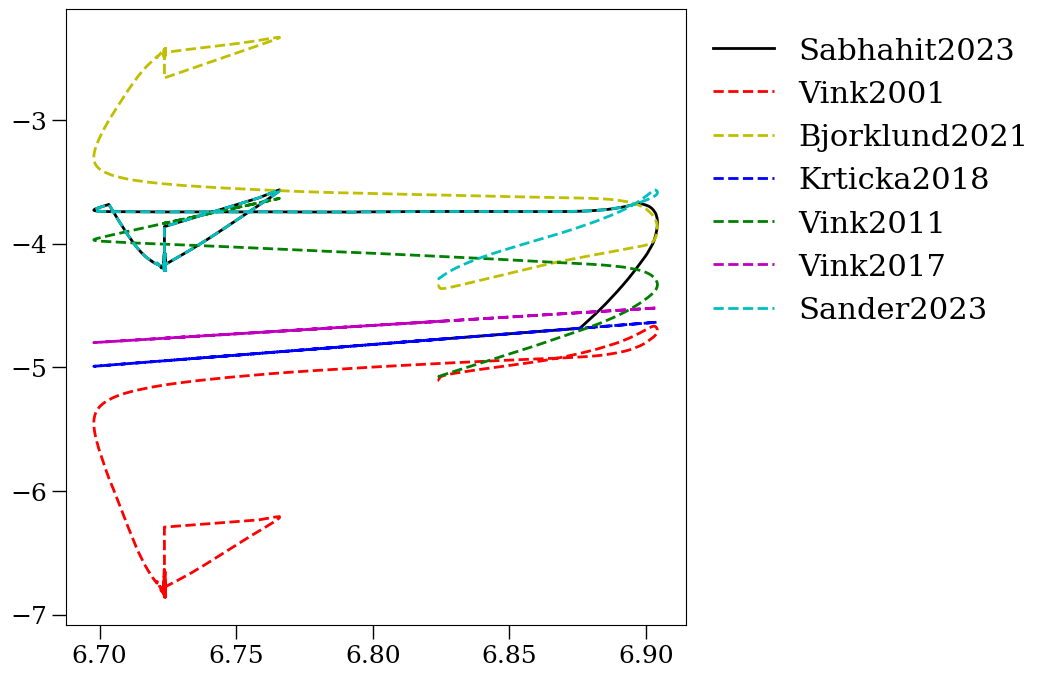

In [343]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_l), np.log10(full_winds), 'k-', label='Sabhahit2023')
ax.plot(np.log10(wind_test_l), np.log10(v01_winds), 'r--', label='Vink2001')
ax.plot(np.log10(wind_test_l), np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(np.log10(wind_test_l), np.log10(k18_winds), 'b--', label='Krticka2018')
ax.plot(np.log10(wind_test_l), np.log10(v11_winds), 'g--', label='Vink2011')

ax.plot(np.log10(wind_test_l), np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(np.log10(wind_test_l), np.log10(s23_winds), 'c--', label='Sander2023')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

#ax.set_xlim(5.3, 6.2)
#ax.set_ylim(-10, -2)

(-10.0, -2.0)

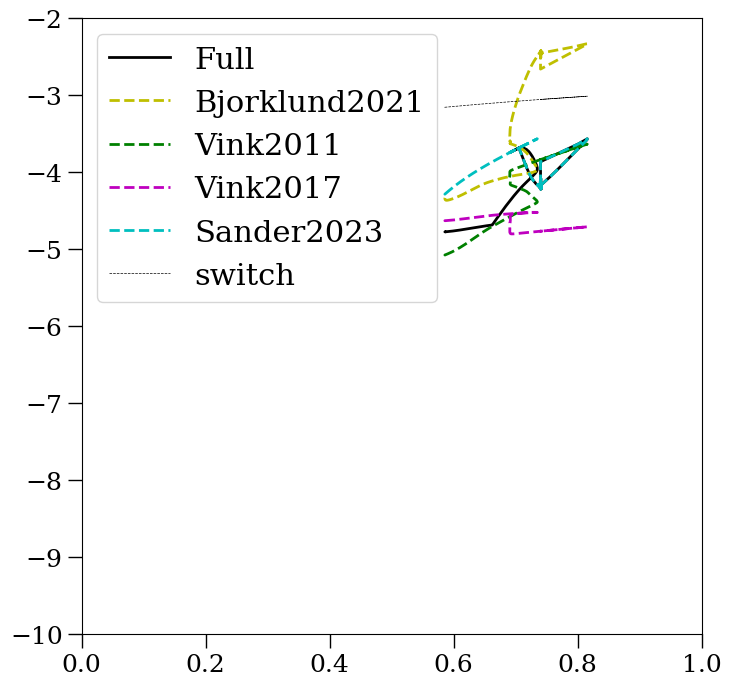

In [344]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wind_test_g, np.log10(full_winds), 'k-', label='Full')
ax.plot(wind_test_g, np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(wind_test_g, np.log10(v11_winds), 'g--', label='Vink2011')
ax.plot(wind_test_g, np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(wind_test_g, np.log10(s23_winds), 'c--', label='Sander2023')
ax.plot(wind_test_g, np.log10(wind_test_g/g_switch)-3, 'k--', lw=0.5, label='switch')
ax.legend()

ax.set_xlim(0, 1)
ax.set_ylim(-10, -2)

(-10.0, -2.0)

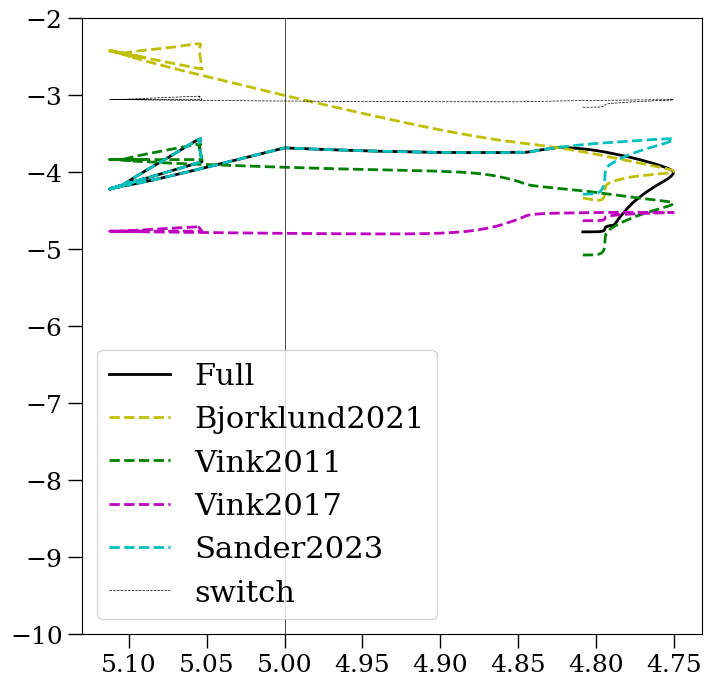

In [345]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_t), np.log10(full_winds), 'k-', label='Full')
ax.plot(np.log10(wind_test_t), np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(np.log10(wind_test_t), np.log10(v11_winds), 'g--', label='Vink2011')
ax.plot(np.log10(wind_test_t), np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(np.log10(wind_test_t), np.log10(s23_winds), 'c--', label='Sander2023')
ax.plot(np.log10(wind_test_t), np.log10(wind_test_g/g_switch)-3, 'k--', lw=0.5, label='switch')
ax.invert_xaxis()
ax.legend()
ax.vlines(5, -10, -2, color='k', lw=0.5)

#ax.set_xlim(0, 1)
ax.set_ylim(-10, -2)

In [346]:
mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
mesa_rotational_logmdot = np.log10(10.**mesa_wind_rot - 10.**mesa_wind)

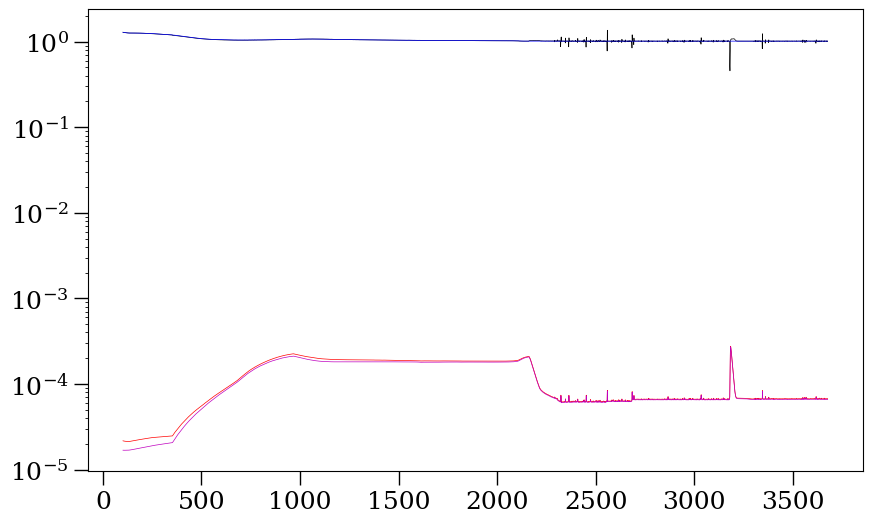

In [347]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wind_test_model_n, 10.**mesa_wind_rot, 'r-', lw=0.5)
ax.plot(wind_test_model_n, 10.**mesa_wind_rot/full_winds, 'k-', lw=0.5)
ax.plot(wind_test_model_n, wind_test_h.rotational_mdot_boost[wind_test_start_i:], 'b-', lw=0.5)
ax.plot(wind_test_model_n, 10.**mesa_wind_rot/wind_test_h.rotational_mdot_boost[wind_test_start_i:], 'm-', lw=0.5)
ax.set_yscale('log')

Text(0, 0.5, '$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

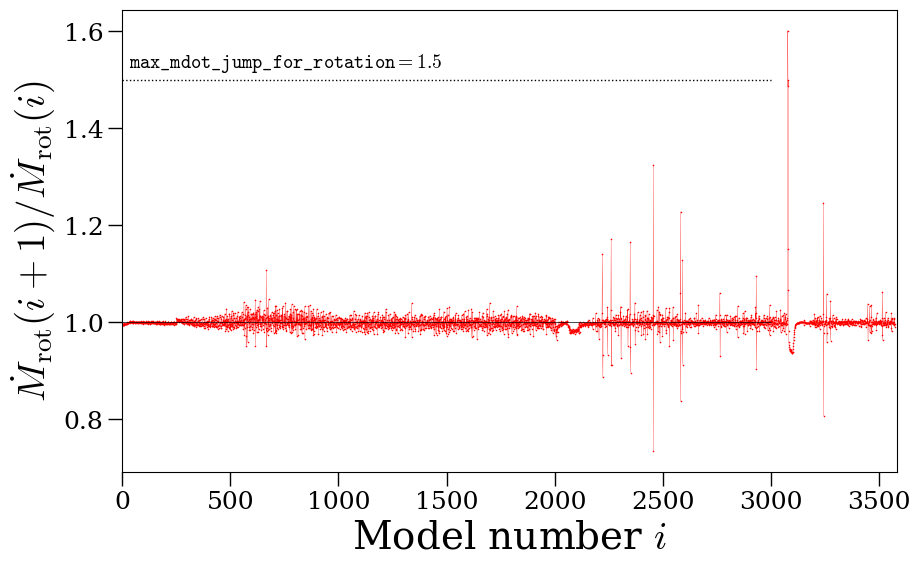

In [348]:
fig, ax = plt.subplots(figsize=(10, 6))

mdot_wind_jump = 10.**mesa_rotational_logmdot[1:]/10.**mesa_rotational_logmdot[:-1]
ax.plot(mdot_wind_jump, 'rx-', lw=0.2, markersize=0.5)
ax.hlines(1, 0, 3000, color='k', lw=0.5)
ax.set_xlim(0, len(mdot_wind_jump)+10)

ax.hlines(1.5, 0, 3000, color='k', ls=':', lw=1)
ax.text(30, 1.51, '$\\tt{max\\_mdot\\_jump\\_for\\_rotation=1.5}$', ha='left', va='bottom', fontsize=14)

ax.set_xlabel('Model number $i$')
ax.set_ylabel('$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

Text(0, 0.5, '$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

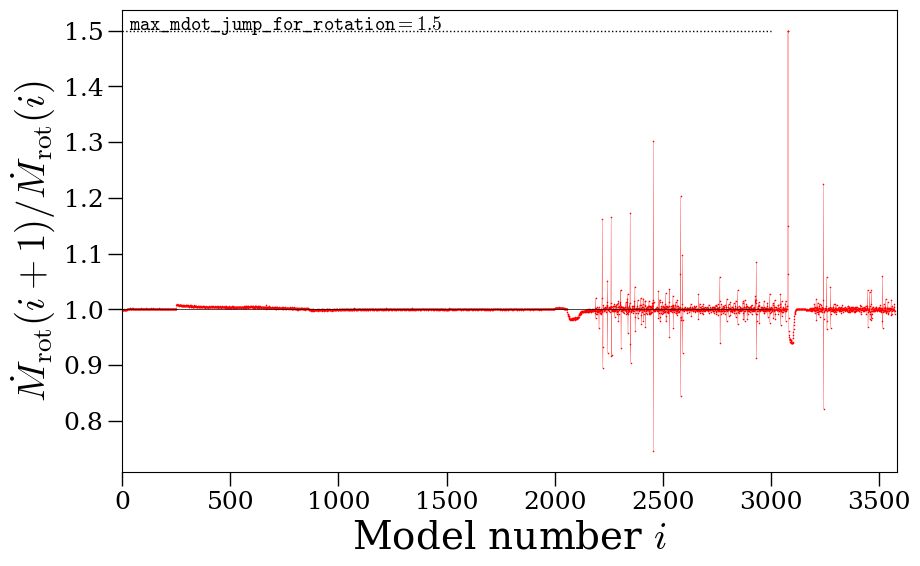

In [349]:
fig, ax = plt.subplots(figsize=(10, 6))

mdot_wind_jump = 10.**mesa_wind_rot[1:]/10.**mesa_wind_rot[:-1]
ax.plot(mdot_wind_jump, 'rx-', lw=0.2, markersize=0.5)
ax.hlines(1, 0, 3000, color='k', lw=0.5)
ax.set_xlim(0, len(mdot_wind_jump)+10)

ax.hlines(1.5, 0, 3000, color='k', ls=':', lw=1)
ax.text(30, 1.49, '$\\tt{max\\_mdot\\_jump\\_for\\_rotation=1.5}$', ha='left', va='bottom', fontsize=14)

plt.xlabel('Model number $i$')
plt.ylabel('$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

/tmp/ipykernel_113957/500473123.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


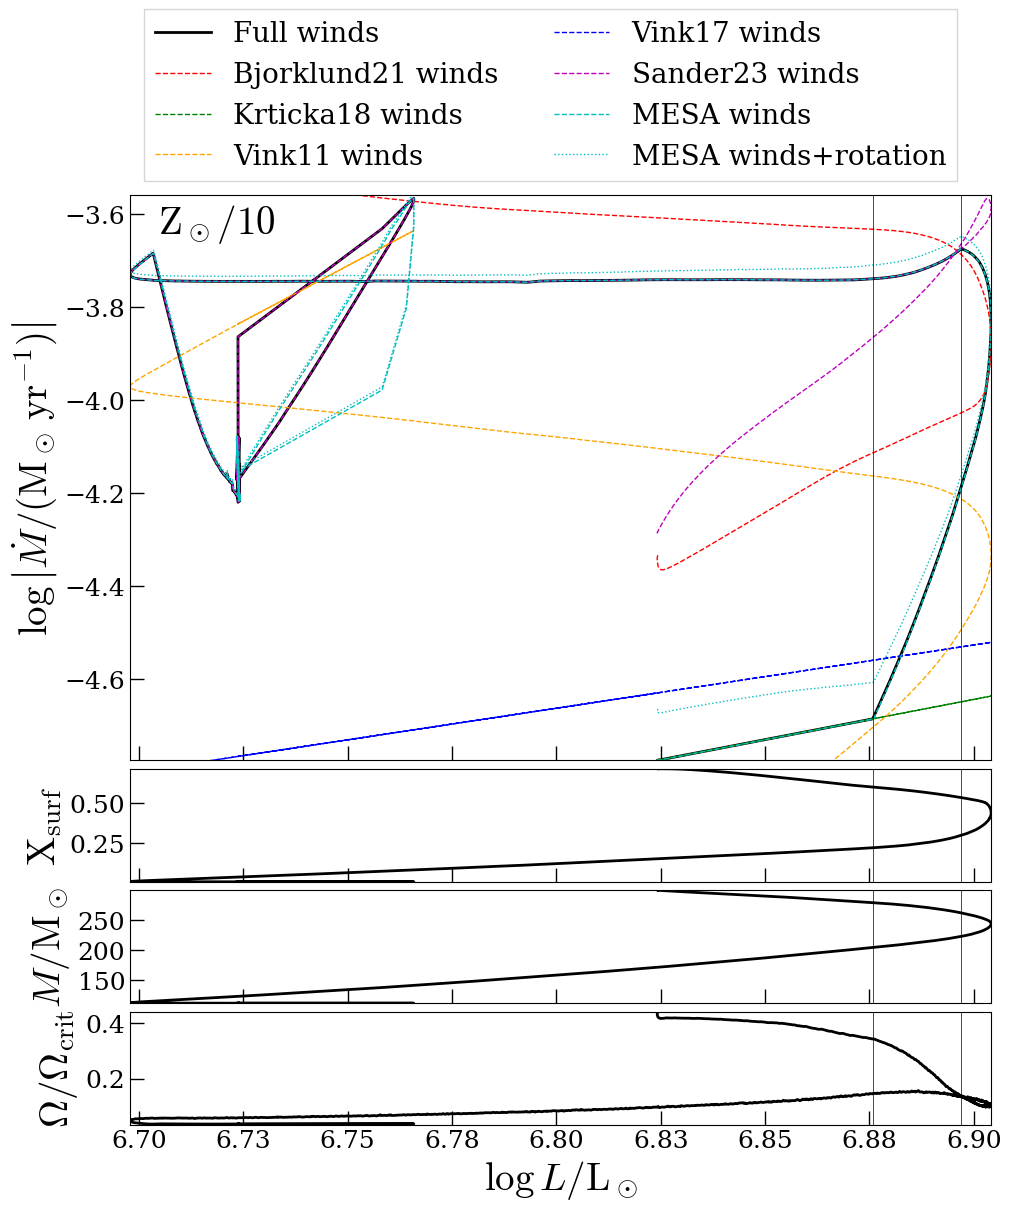

In [357]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_m40_p060_zsun_div_10')

/tmp/ipykernel_113957/632979289.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


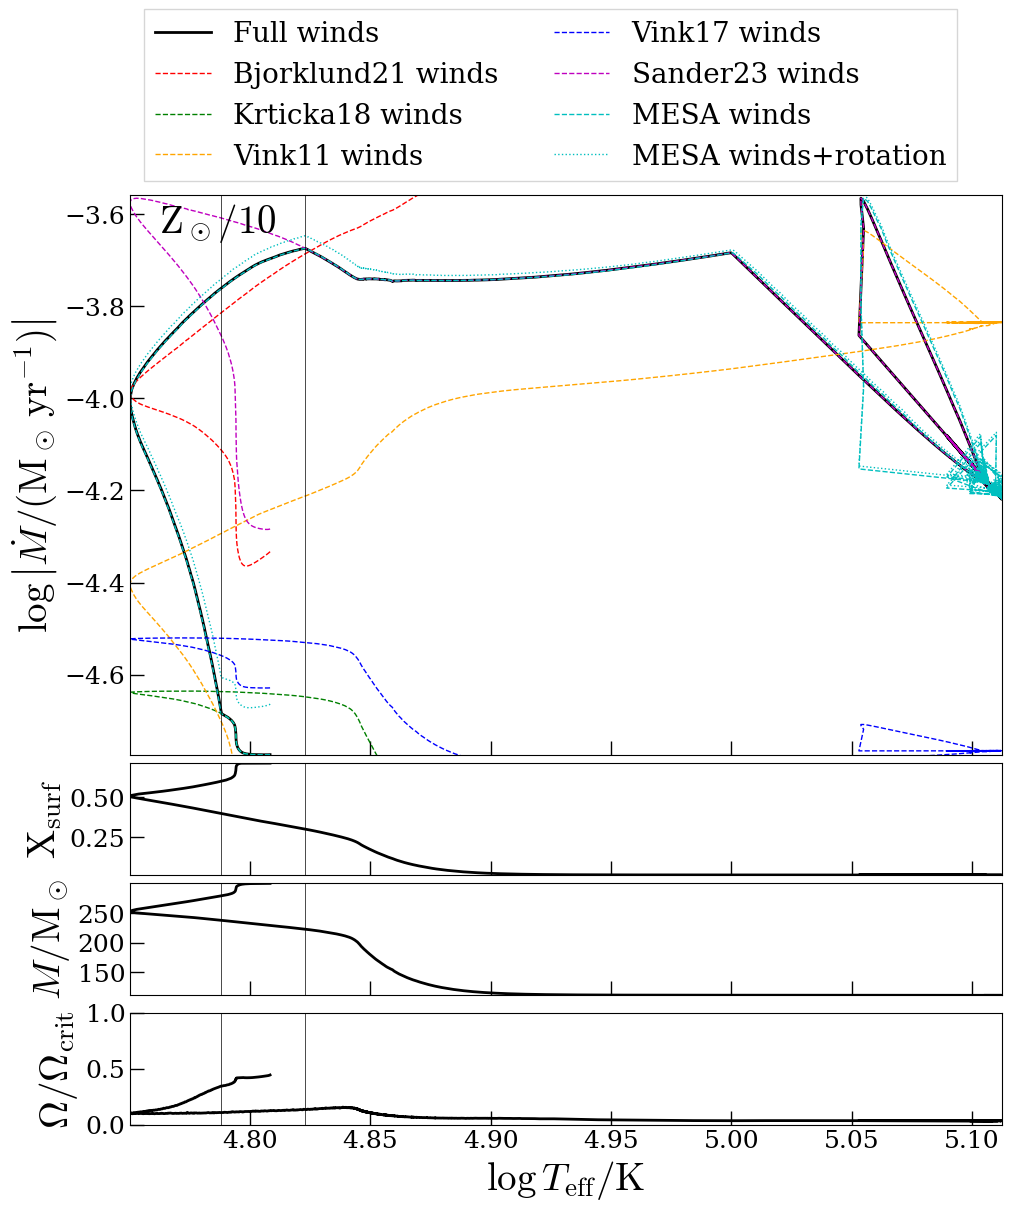

In [351]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_t)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_Teff[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_h.log_Teff[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_Teff[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_Teff[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_teff_m40_p060_zsun_div_10')

/tmp/ipykernel_113957/723071273.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


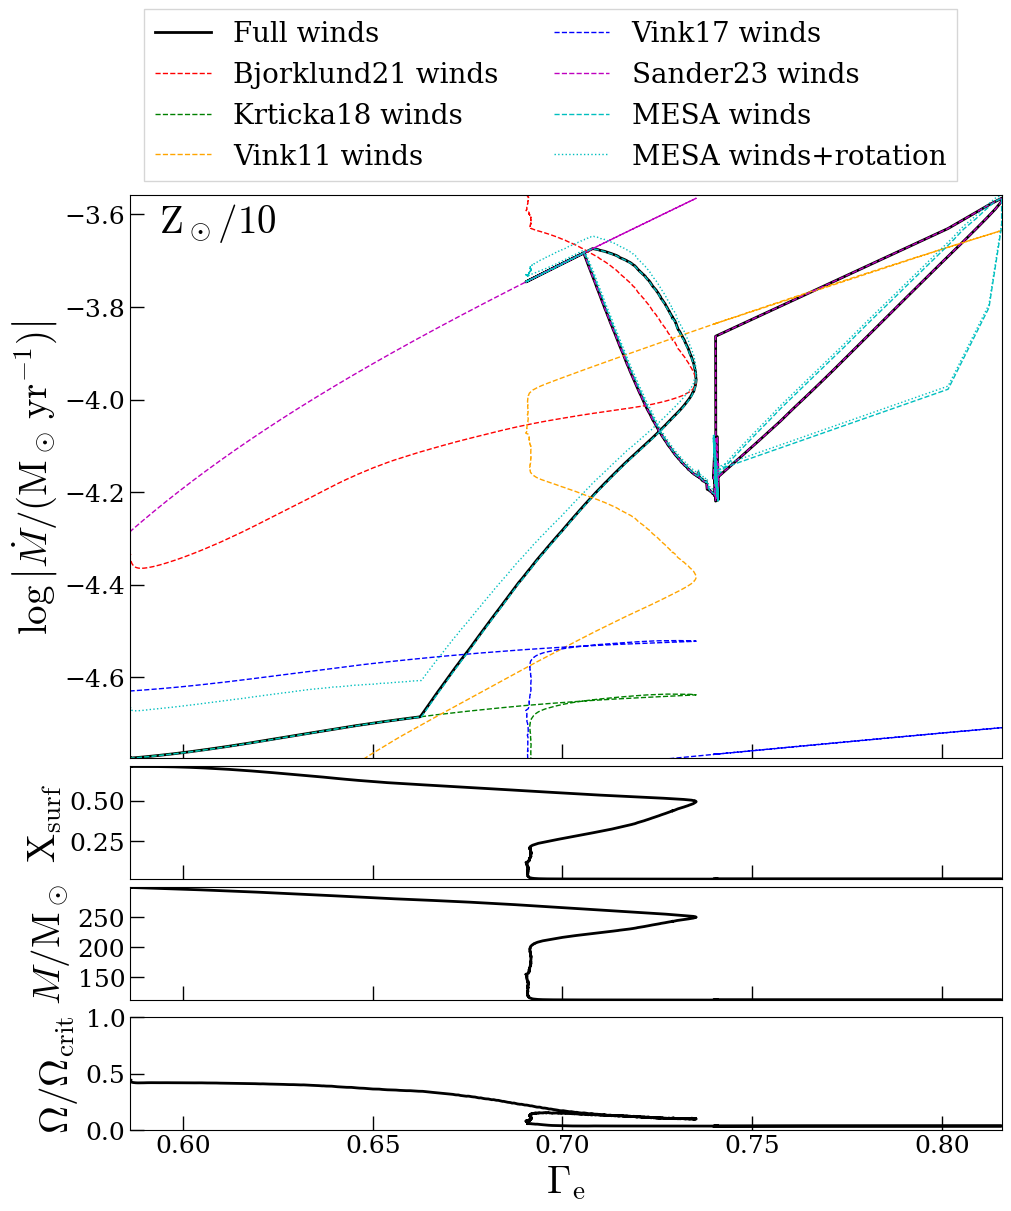

In [352]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_g
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_g, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_g, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_g
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_g
except:
    y1_log_l = maxy + 1
    
#ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_g, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

#ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_g, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

#ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(wind_test_g, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\Gamma_\\mathrm{e}$')

#ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_eddgamma_m40_p060_zsun_div_10')

/tmp/ipykernel_113957/2127760473.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


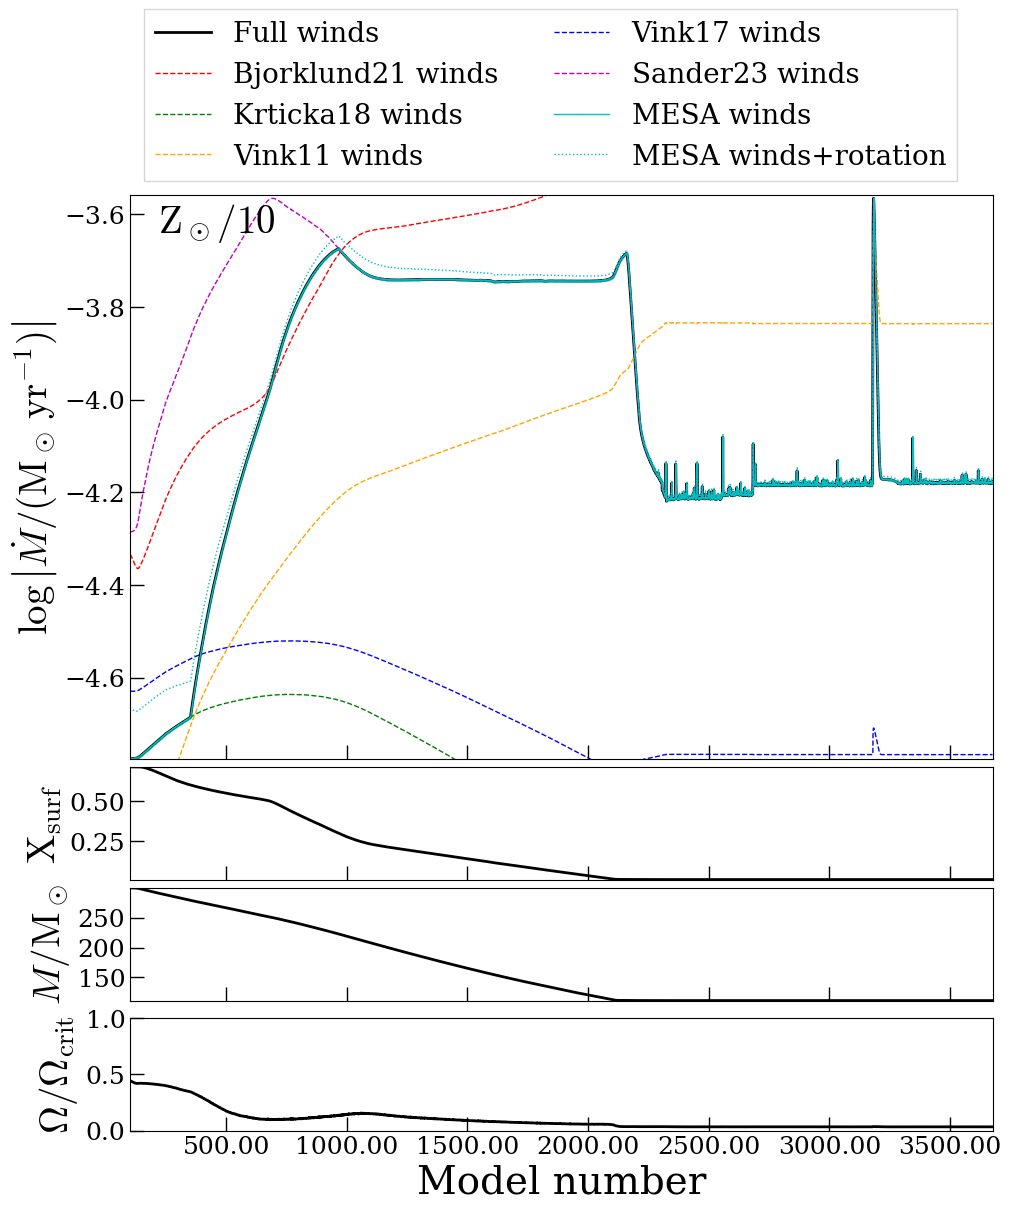

In [363]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_model_n
minx = min(x)
maxx = max(x)

#ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'co-', label='MESA winds', lw=1, markersize=0.1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = x[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = x[y1_i]
except:
    y1_log_l = maxy + 1
    
#ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

#ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

#ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('Model number')

#ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_eddgamma_m40_p060_zsun_div_10')

/tmp/ipykernel_113957/3197302260.py:106: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


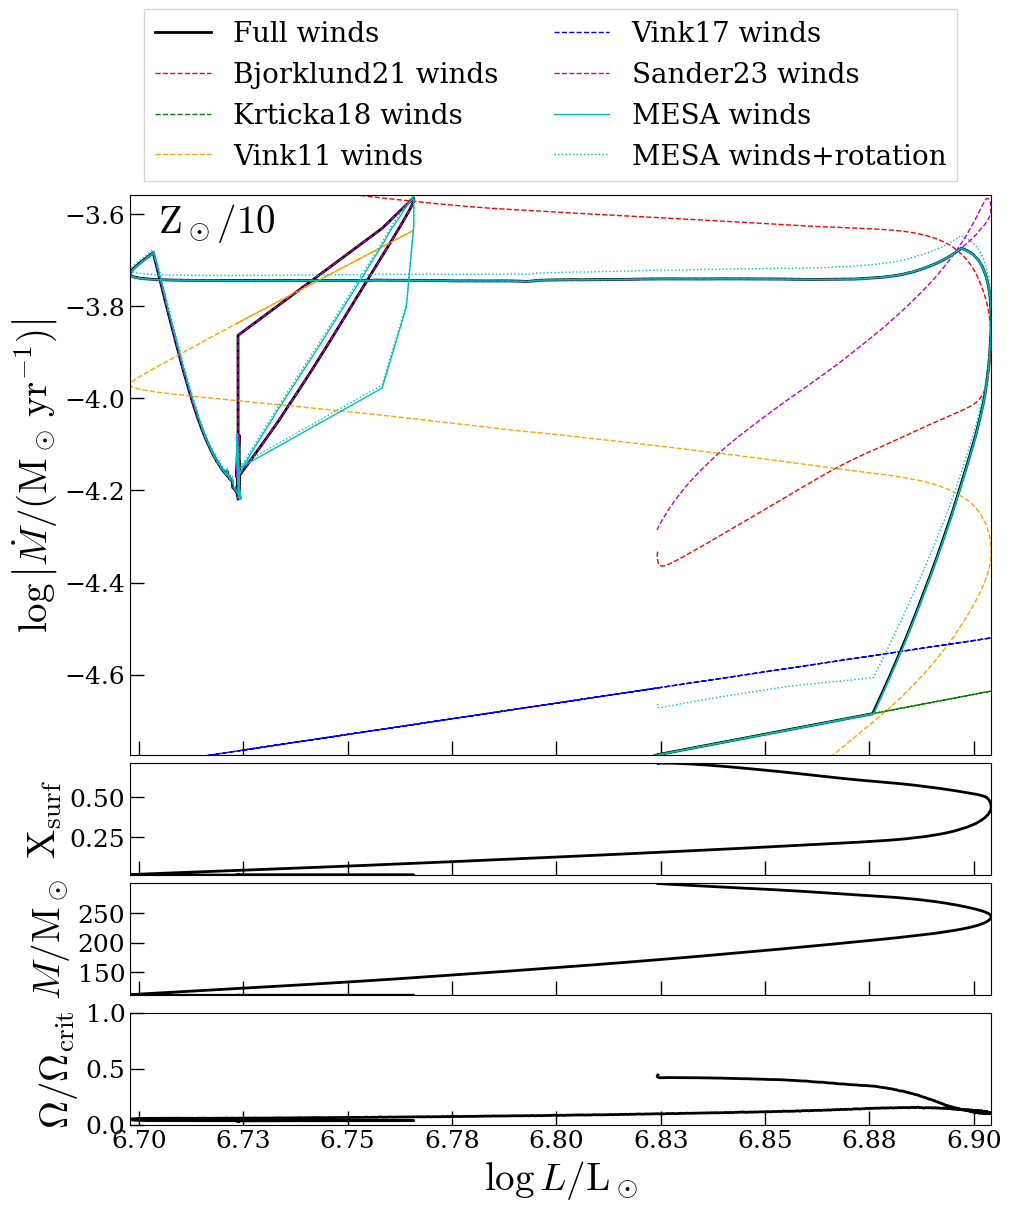

In [364]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'co-', label='MESA winds', lw=1, markersize=0.1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = x[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = x[y1_i]
except:
    y1_log_l = maxy + 1
    
#ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

#ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

#ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

#ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_eddgamma_m40_p060_zsun_div_10')

In [354]:
def terminal_v(l, m, r, z, x):
    g_e = edd_gamma(x, l, m)
    m *= u.Msun
    r *= u.Rsun
    v = (2.6
         * np.sqrt((2*ct.G.cgs * m * (1-g_e))/r)
         * (z/Z_SUN)**0.2
         )
    v = v.to(u.cm/u.s)
    return v.value

def ter_esc_v_ratio(l, m, z, x):
    g_e = edd_gamma(x, l, m)
    ratio = 2.6 * np.sqrt(1-g_e) * (z/Z_SUN)**0.2
    return ratio

def wind_eta(mdot, l, m, r, z, x):
    mdot *= u.Msun/u.yr
    ter_v = terminal_v(l, m, r, z, x) * u.cm/u.s
    eta = (mdot * ter_v / (l*u.Lsun/ ct.c)).to(u.dimensionless_unscaled)
    return eta.value

def wind_f(l, m, z, x):
    v_ratio = ter_esc_v_ratio(l, m, z, x)
    f = 0.75/(1+v_ratio**-2)
    return f

In [355]:
test_wind_eta_b21 = wind_eta(
    b21_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_eta_k18 = wind_eta(
    k18_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_eta_v01 = wind_eta(
    v01_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_f = wind_f(
    wind_test_l,
    wind_test_m,
    wind_test_z,
    wind_test_x
)

(0.1, 10)

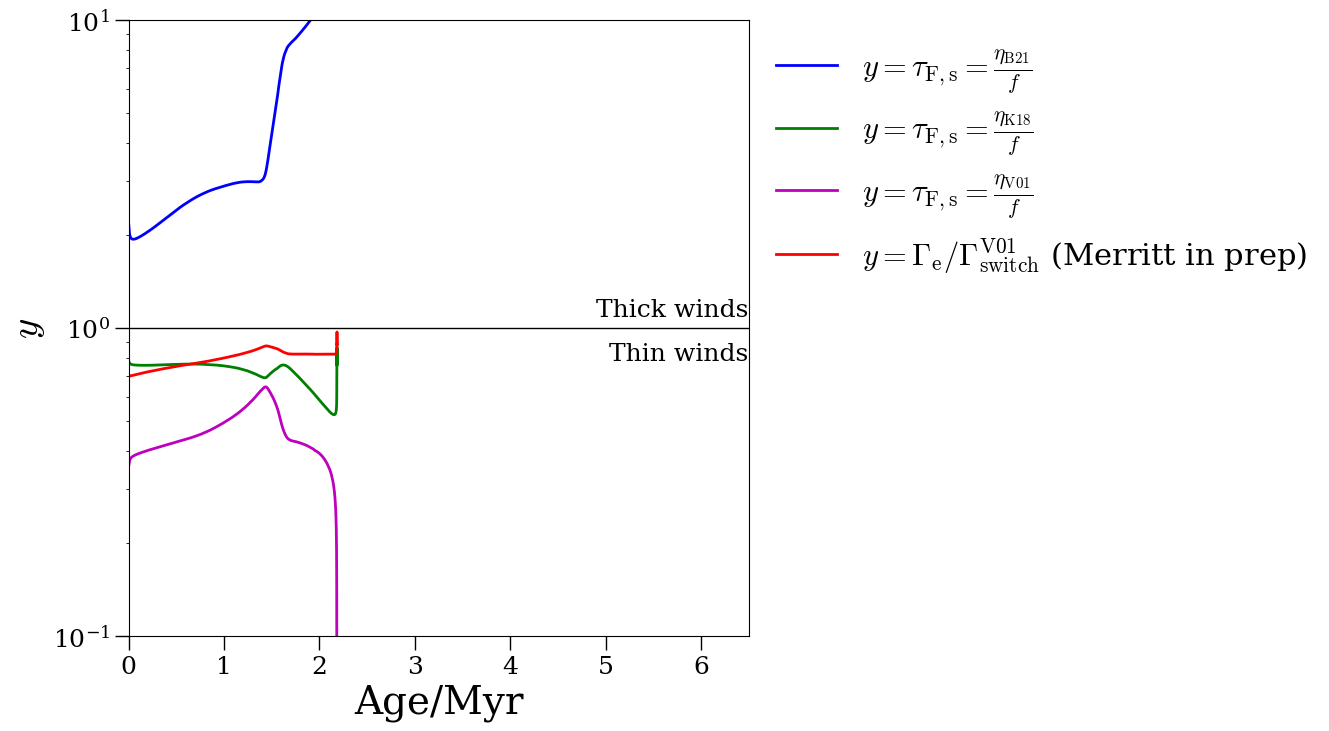

In [356]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wind_test_age/1e6, test_wind_eta_b21/test_wind_f, 'b-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{B21}}{f}$')
ax.plot(wind_test_age/1e6, test_wind_eta_k18/test_wind_f, 'g-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{K18}}{f}$')
ax.plot(wind_test_age/1e6, test_wind_eta_v01/test_wind_f, 'm-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{V01}}{f}$')
ax.plot(wind_test_age/1e6, wind_test_g/g_switch, 'r-', label='$y=\\Gamma_\\mathrm{e}/\\Gamma_\\mathrm{switch}^\\mathrm{V01}$ (Merritt in prep)')
ax.set_yscale('log')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ax.set_xlabel('Age/Myr')
ax.set_ylabel('$y$')

ax.hlines(1, 0, 7, color='k', lw=1)
ax.set_xlim(0, 6.5)

ax.text(6.5, 0.9, 'Thin winds', ha='right', va='top', fontsize=18)
ax.text(6.5, 1.05, 'Thick winds', ha='right', va='bottom', fontsize=18)

ax.set_ylim(0.1, 10)